In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def gen_d(rand_points, p):
    result = [np.random.binomial(1, p)]
    
    for t in rand_points[1:]:
        result.append(np.random.binomial(1, p)*t + (1-t)*result[-1])
    
    return np.array(result)


def y_given_d(d, effect_params=[3,2,1], T=120):
    return np.random.normal(np.log(np.arange(1, T+1))+np.convolve(d, effect_params)[:-(len(effect_params)-1)])


T = 120
m = 2
p = 0.5

# correct tau = 3+2+1=6
effect_params = [3,2,1]

## Possible Designs

In [2]:
d0 = np.zeros(T)
d1 = np.ones(T)

# randomize every period
rand_points_every = np.ones(T)==1
np.random.seed(1)
d_every = gen_d(rand_points_every, p)


# randomize every m periods
rand_points_equal = np.arange(0, T)%(m+1)==0
np.random.seed(1)
d_equal = gen_d(rand_points_equal, p)


# optimmal design
n = int(T/m)
rand_points_index_opt = [1] + [i*m + 1 for i in range(2, int(n-1))]
rand_points_opt = np.isin(np.arange(1, 121), rand_points_index_opt)
np.random.seed(1)
d_opt = gen_d(rand_points_opt, p)

### Simulate Outcomes

In [3]:
np.random.seed(1)
y0 = y_given_d(d0)

np.random.seed(1)
y1 = y_given_d(d1)

np.random.seed(1)
y_opt = y_given_d(d_opt)

np.random.seed(1)
y_equal = y_given_d(d_equal)

np.random.seed(1)
y_every = y_given_d(d_every)

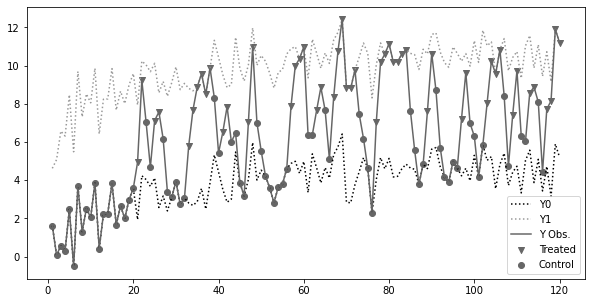

In [4]:
plt.figure(figsize=(10,5))
x = np.arange(1, T+1)
plt.plot(x, y0, ls=":", color="0.0", label="Y0")
plt.plot(x, y1, ls=":", color="0.6", label="Y1")
plt.plot(x, y_opt, color="0.4", label="Y Obs.")
plt.scatter(x[d_opt==1], y_opt[d_opt==1], label="Treated", marker="v", color="0.4")
plt.scatter(x[d_opt==0], y_opt[d_opt==0], label="Control", marker="o", color="0.4")

plt.legend();

# Estimation

In [5]:
from numpy.lib.stride_tricks import sliding_window_view

def iptw_switchback(d, y, rand_points, p, m):
    
    n_windows_last_m = np.diff(sliding_window_view(rand_points.cumsum(), (m+1)), axis=1).sum(axis=1)+1
    p_last_m_equal = p**n_windows_last_m
    
    last_m_is_1 = (sliding_window_view(d, m+1)==1).all(axis=1)
    last_m_is_0 = (sliding_window_view(d, m+1)==0).all(axis=1)
  
    y1_rec = y[m:]*last_m_is_1/p_last_m_equal
    y0_rec = y[m:]*last_m_is_0/p_last_m_equal
    
    return (y1_rec-y0_rec).mean()

In [6]:
iptw_switchback(d_every, y_every, rand_points_every, 0.5, m)

7.645971432685497

In [7]:
iptw_switchback(d_equal, y_equal, rand_points_equal, 0.5, m)

6.625077990563234

In [8]:
iptw_switchback(d_opt, y_opt, rand_points_opt, 0.5, m)

2.3770431202743008

## Simulate Many Experiments

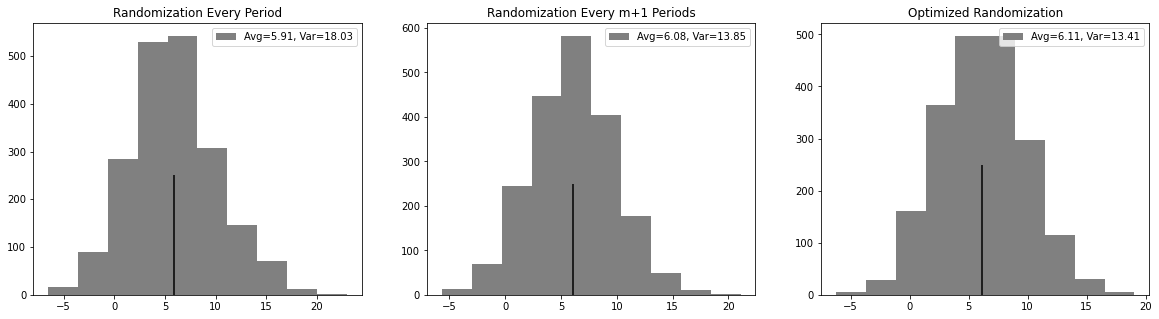

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
np.random.seed(123)

n_sim = 2000

ds_equal = [np.repeat(np.random.binomial(1, 0.5, T//(m+1)), m+1) for _ in range(n_sim)]
taus_equal = [iptw_switchback(d, y_given_d(d), rand_points_equal, p, m) for d in ds_equal]

ds_every = [np.random.binomial(1, 0.5, T) for _ in range(n_sim)]
taus_every = [iptw_switchback(d, y_given_d(d), rand_points_every, p, m) for d in ds_every]

ds_opt = [gen_d(rand_points_opt, p=p) for _ in range(n_sim)]
taus_opt = [iptw_switchback(d, y_given_d(d), rand_points_opt, p, m) for d in ds_opt]


ax1.hist(taus_every, color="0.5", label=f"Avg={np.round(np.mean(taus_every), 2)}, Var={np.round(np.var(taus_every), 2)}")
ax1.vlines(np.mean(taus_every), 0, 250, color="black")
ax1.set_title("Randomization Every Period")
ax1.legend()

ax2.hist(taus_equal, color="0.5", label=f"Avg={np.round(np.mean(taus_equal), 2)}, Var={np.round(np.var(taus_equal), 2)}")
ax2.vlines(np.mean(taus_equal), 0, 250, color="black")
ax2.set_title("Randomization Every m+1 Periods")
ax2.legend()

ax3.hist(taus_opt, color="0.5", label=f"Avg={np.round(np.mean(taus_opt), 2)}, Var={np.round(np.var(taus_opt), 2)}")
ax3.vlines(np.mean(taus_opt), 0, 250, color="black")
ax3.set_title("Optimized Randomization")
ax3.legend();

## Inference

In [10]:
def var_opt_design(y_opt, d_opt, T, m):
    
    assert (T//m == T/m) & (T//m > 4), "T must be divisible by m and T/m > 4"
    
    # discard 1st block
    y_m_blocks = np.vstack(np.hsplit(y_opt, int(T/m))).sum(axis=1)[1:]
    d_m_blocks = np.vstack(np.split(d_opt, int(T/m))[1:])[:, -1]

    return (
        8*y_m_blocks[0]**2 
        + (32*y_m_blocks[1:-1]**2*(np.diff(d_m_blocks)==0)[:-1]).sum()
        + 8*y_m_blocks[-1]**2 
    ) / (T-m)**2


In [11]:
var_hat = var_opt_design(y_opt, d_opt, T, m)
var_hat

10.802196672460955

In [12]:
se = np.sqrt(var_hat)

tau_opt = iptw_switchback(d_opt, y_opt, rand_points_opt, 0.5, m)

ci_95 = [tau_opt-1.96*se, tau_opt+1.96*se]
ci_95

[-4.064829180301519, 8.81891542085012]

## Conservative Variance

In [13]:
np.random.seed(123)
ds_opt = [gen_d(rand_points_opt, p=p) for _ in range(1000)]

vars_opt = [var_opt_design(y_given_d(d), d, T, m) for d in ds_opt]


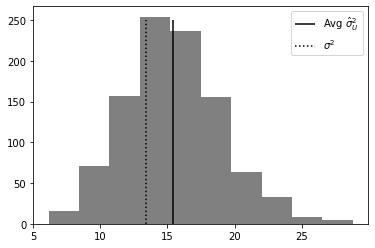

In [14]:
plt.hist(vars_opt, color="0.5");
plt.vlines(np.mean(vars_opt), 0, 250, color="black", label="Avg $\hat{\sigma}^2_U$")
plt.vlines(np.var(taus_opt), 0, 250, color="black", ls=":", label="$ \sigma^2$")
plt.legend();

## Finding M

In [15]:
from scipy.stats import norm


# unknown
m = 3
effect_params_m3 = [3,2,1,1] # true tau=7


def gen_opt_design(lags, T=T):
    assert T//lags == T/lags
    n = T//lags
    rand_points_index_opt = [1] + [i*lags + 1 for i in range(2, int(n-1))]
    rand_points_opt = np.isin(np.arange(1, T+1), rand_points_index_opt)
    
    return rand_points_opt

### Generate Multiple Designs

In [16]:
# 240 is very convenient, as it is divisible by 1 to 6
T = 120*3
p = 0.5

# l=1 is a special case
designs = [np.ones(T)==1] + [gen_opt_design(lags=l, T=T) for l in range(2,7)]

### Testing Different Ms

In [17]:
def test_equal_taus(tau1, tau2, var1, var2):
    z = np.abs(tau1 - tau2)/np.sqrt(var1+var2)
    p_val = 2 - 2*norm.cdf(z) 
    return p_val


def test_m_leq_lag(design_lag, design_lag_plus_1, p=0.5, T=T):
    
    # run experiments
    d_lag = gen_d(design_lag, p)
    y_lag = y_given_d(d_lag, effect_params=effect_params_m3, T=T)
    
    d_lag_plus1 = gen_d(design_lag_plus_1, p)
    y_lag_plus1 = y_given_d(d_lag_plus1, effect_params=effect_params_m3, T=T)
    
    
    # estimate tau and var
    m_lag = int(np.floor(1/design_lag.mean())) # approximate way to find small ms
    tau_lag = iptw_switchback(d_lag, y_lag, design_lag, p=p, m=m_lag)
    var_lag = var_opt_design(y_lag, d_lag, T, m=m_lag)
    
    tau_lag_plus_1 = iptw_switchback(d_lag_plus1, y_lag_plus1, design_lag_plus_1, p=p, m=m_lag+1)
    var_lag_plus_1 = var_opt_design(y_lag_plus1, d_lag_plus1, T, m=m_lag+1)
    
    return test_equal_taus(tau_lag, tau_lag_plus_1, var_lag, var_lag_plus_1)
    

In [18]:
np.random.seed(1)
p_vals = [test_m_leq_lag(d1, d_plus_1) for d1, d_plus_1 in zip(designs, designs[1:])]
p_vals

[0.3086885175400189,
 0.03787749271192742,
 0.7820533638245117,
 0.6434151372743195,
 0.7964295170247466]

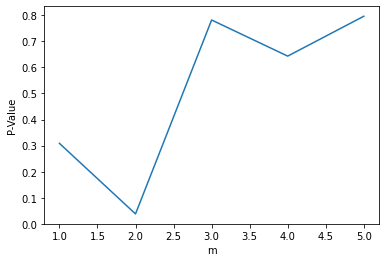

In [19]:
plt.plot(range(1, len(p_vals)+1), p_vals)
plt.ylabel("P-Value")
plt.xlabel("m");